In [0]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.1.0

# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.1.0")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.1.0, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

import networkx as nx
import pandas as pd
import numpy as np
import itertools
import os

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import stellargraph as sg
from stellargraph import globalvar
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt

%matplotlib inline

## Loading the dataset

In [0]:
dataset = datasets.Cora()
graph_full, labels = dataset.load()
#print(graph_full.info())
labels_sampled = labels.sample(frac=0.8, replace=False, random_state=101)
graph_sampled = graph_full.subgraph(labels_sampled.index)
#print(graph_sampled.info())

In [0]:
train_labels, test_labels = model_selection.train_test_split(labels_sampled,train_size=0.25,test_size=None,stratify=labels_sampled,random_state=42)
val_labels, test_labels = model_selection.train_test_split(test_labels, train_size=0.2, test_size=None, stratify=test_labels, random_state=100)

target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_labels)
val_targets = target_encoding.transform(val_labels)
test_targets = target_encoding.transform(test_labels)

In [0]:
generator = GraphSAGENodeGenerator(graph_sampled, 50, [10, 10])
train_gen = generator.flow(train_labels.index, train_targets, shuffle=False)

In [0]:
graphsage_model = GraphSAGE(layer_sizes=[32, 32], generator=generator, bias=True, dropout=0.5)
x_inp, x_out = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

model = Model(inputs=x_inp, outputs=prediction)
model.compile(optimizer=optimizers.Adam(lr=0.005),loss=losses.categorical_crossentropy,metrics=["acc"])

26/26 [==============================] - 3s 103ms/step - loss: 0.7879 - acc: 0.7969

Test Set Metrics:
	loss: 0.7879
	acc: 0.7969


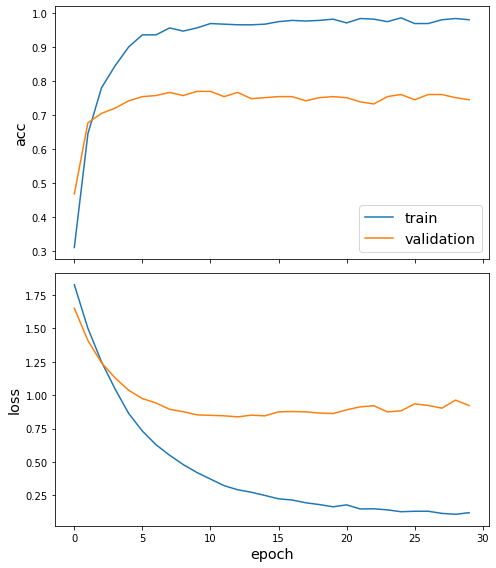

In [6]:
val_gen = generator.flow(val_labels.index, val_targets)
history = model.fit(train_gen, epochs=30, validation_data=val_gen, verbose=0, shuffle=False)
sg.utils.plot_history(history)

test_gen = generator.flow(test_labels.index, test_targets)
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

In [7]:
#Hold out set
generator = GraphSAGENodeGenerator(graph_full, 50, [10, 10])
hold_out_nodes = labels.index.difference(labels_sampled.index)
labels_hold_out = labels[hold_out_nodes]

hold_out_targets = target_encoding.transform(labels_hold_out)
hold_out_gen = generator.flow(hold_out_nodes, hold_out_targets)

hold_out_predictions = model.predict(hold_out_gen)
hold_out_predictions = target_encoding.inverse_transform(hold_out_predictions)

hold_out_metrics = model.evaluate(hold_out_gen)
print("\nHold Out Set Metrics:")
for name, val in zip(model.metrics_names, hold_out_metrics):
    print("\t{}: {:0.4f}".format(name, val))

11/11 [==============================] - 1s 59ms/step - loss: 0.6915 - acc: 0.8100

Hold Out Set Metrics:
	loss: 0.6915
	acc: 0.8100


In [8]:
print(len(train_targets))
print(len(hold_out_targets))

541
542


# **Shadow Model**

In [0]:
shadow_labels_sampled = labels.sample(frac=0.6, replace=False, random_state=10)
shadow_graph = graph_full.subgraph(shadow_labels_sampled.index)



shadow_train_labels, shadow_test_labels = model_selection.train_test_split(shadow_labels_sampled,train_size=0.7,test_size=None,stratify=shadow_labels_sampled,random_state=42)
shadow_val_labels, shadow_test_labels = model_selection.train_test_split(shadow_test_labels, train_size=0.2, test_size=None, stratify=shadow_test_labels, random_state=100)

target_encoding = preprocessing.LabelBinarizer()

shadow_train_targets = target_encoding.fit_transform(shadow_train_labels)
shadow_val_targets = target_encoding.transform(shadow_val_labels)
shadow_test_targets = target_encoding.transform(shadow_test_labels)

In [0]:
shadow_generator = GraphSAGENodeGenerator(shadow_graph, 50, [10, 10])
shadow_train_gen = shadow_generator.flow(shadow_train_labels.index, shadow_train_targets, shuffle=False)


shadow_model = GraphSAGE(layer_sizes=[32, 32], generator=shadow_generator, bias=True, dropout=0.5)
x_inp1, x_out1 = shadow_model.in_out_tensors()
prediction1 = layers.Dense(units=shadow_train_targets.shape[1], activation="softmax")(x_out1)

shadow_model = Model(inputs=x_inp1, outputs=prediction1)
shadow_model.compile(optimizer=optimizers.Adam(lr=0.005),loss=losses.categorical_crossentropy,metrics=["acc"])

8/8 [==============================] - 1s 83ms/step - loss: 0.7503 - acc: 0.8159

Test Set Metrics:
	loss: 0.7503
	acc: 0.8159


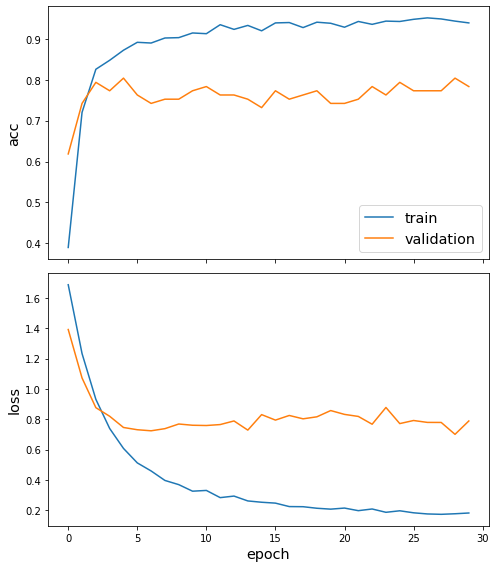

In [11]:
shadow_val_gen = shadow_generator.flow(shadow_val_labels.index, shadow_val_targets)
history1 = shadow_model.fit(shadow_train_gen, epochs=30, validation_data=shadow_val_gen, verbose=0, shuffle=False)
sg.utils.plot_history(history1)

shadow_test_gen = shadow_generator.flow(shadow_test_labels.index, shadow_test_targets)
test_metrics1 = shadow_model.evaluate(shadow_test_gen)
print("\nTest Set Metrics:")
for name, val in zip(shadow_model.metrics_names, test_metrics1):
    print("\t{}: {:0.4f}".format(name, val))

In [12]:
#Hold out set
shadow_generator = GraphSAGENodeGenerator(graph_full, 50, [10, 10])
shadow_hold_out_nodes = labels.index.difference(shadow_labels_sampled.index)
shadow_labels_hold_out = labels[shadow_hold_out_nodes]

shadow_hold_out_targets = target_encoding.transform(shadow_labels_hold_out)
shadow_hold_out_gen = shadow_generator.flow(shadow_hold_out_nodes, shadow_hold_out_targets)

hold_out_predictions1 = shadow_model.predict(shadow_hold_out_gen)
hold_out_predictions1 = target_encoding.inverse_transform(hold_out_predictions1)

hold_out_metrics1 = shadow_model.evaluate(shadow_hold_out_gen)
print("\nHold Out Set Metrics:")
for name, val in zip(shadow_model.metrics_names, hold_out_metrics1):
    print("\t{}: {:0.4f}".format(name, val))

22/22 [==============================] - 1s 60ms/step - loss: 0.5698 - acc: 0.8523

Hold Out Set Metrics:
	loss: 0.5698
	acc: 0.8523


In [13]:
print(len(shadow_train_targets))
print(len(shadow_hold_out_targets))

1137
1083


# **Inference Accuracy**

In [14]:
shadow_train=shadow_model.predict(shadow_train_gen)
shadow_test=shadow_model.predict(shadow_hold_out_gen)
y_shadow_train=[1]*shadow_train_targets.shape[0]
y_shadow_test=[0]*shadow_hold_out_targets.shape[0]
print(len(y_shadow_train))
print(len(y_shadow_test))
y_train_attack=y_shadow_train+y_shadow_test
#print(y_train_attack)
x_train_attack=np.concatenate((np.array(shadow_train),np.array(shadow_test)))
print(x_train_attack.shape)

1137
1083
(2220, 7)


In [15]:
target_train=model.predict(train_gen)
target_test=model.predict(hold_out_gen)
y_target_train=[1]*train_targets.shape[0]
y_target_test=[0]*hold_out_targets.shape[0]
print(len(y_target_train))
print(len(y_target_test))
y_test_attack=y_target_train+y_target_test
#print(y_train_attack)
x_test_attack=np.concatenate((np.array(target_train),np.array(target_test)))
print(x_test_attack.shape)

541
542
(1083, 7)


In [16]:
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
clf = MLPClassifier(random_state=1, solver='adam', max_iter=300).fit(x_train_attack, y_train_attack)
clf.fit(x_train_attack, y_train_attack)
print("Test set score: %f" % clf.score(x_test_attack, y_test_attack))

y_score = clf.predict(x_test_attack)
print(metrics.classification_report(y_test_attack, y_score, labels=range(2)))
print(metrics.roc_auc_score(y_test_attack, y_score))

Test set score: 0.620499
              precision    recall  f1-score   support

           0       0.70      0.43      0.53       542
           1       0.59      0.81      0.68       541

    accuracy                           0.62      1083
   macro avg       0.64      0.62      0.61      1083
weighted avg       0.64      0.62      0.61      1083

0.6206747788365129
